In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [13]:
df=pd.read_csv("../../data/merged/len3_prod_agg_drop_never.csv",encoding="shift-jis",index_col=0)
# df["prod_date"]

Estimation

In [14]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
# df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
# df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
# df["stock_otc_lag"].fillna(0,inplace=True)
# df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
# df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
# df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
# df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
# df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [15]:
# change to the datetime format
# df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 254 entries, (114, 2008) to (799, 2021)
Data columns (total 97 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   efficacy         254 non-null    object 
 1   rx_agg           254 non-null    int64  
 2   rx_pro_agg       254 non-null    int32  
 3   rx_pro_dom       254 non-null    int64  
 4   otc_agg          254 non-null    int64  
 5   otc_pro_agg      254 non-null    int32  
 6   otc_pro_dom      254 non-null    int64  
 7   self_agg         254 non-null    int64  
 8   self_pro_agg     254 non-null    int64  
 9   self_pro_dom     254 non-null    int64  
 10  Approved         254 non-null    float64
 11  KEGG             254 non-null    object 
 12  Ingredient       254 non-null    object 
 13  date             254 non-null    object 
 14  release_year     254 non-null    float64
 15  成分               254 non-null    object 
 16  variable         254 non-null    object 
 17

(97, 14, 21)

In [16]:
# months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [17]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10        -0.1084     0.1615    -0.6716     0.5026     -0.4269      0.2100
elapsed_m9          0.0593     0.1243     0.4773     0.6337     -0.1858      0.3045
elapsed_m8          0.0023     0.1559     0.0148     0.9882     -0.3051      0.3097
elapsed_m7          0.0164     0.2061     0.0795     0.9367     -0.3901      0.4229
elapsed_m6          0.0229     0.1877     0.1221     0.9029     -0.3473      0.3932
elapsed_m5          0.1399     0.1462     0.9569     0.3398     -0.1485      0.4283
elapsed_m4          0.1627     0.1295     1.2567     0.2104     -0.0927      0.4182
elapsed_m3          0.3382     0.1377     2.4557     0.0149      0.0666      0.6098
elapsed_m2          0.3798     0.2190     1.7338     0.0846     -0.0523     

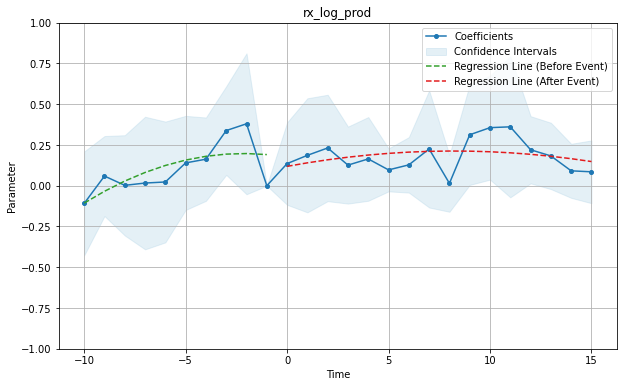

In [24]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
formula+=ytrend

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_prod",title="rx_log_prod",ylim=(-1,1),period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

C:\Users\hakos\AppData\Local\Temp\ipykernel_20376\3519287367.py:21: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10        -0.1187     0.2786    -0.4261     0.6705     -0.6681      0.4308
elapsed_m9          0.2965     0.2848     1.0411     0.2992     -0.2652      0.8582
elapsed_m8          0.0373     0.3281     0.1136     0.9097     -0.6098      0.6843
elapsed_m7          0.0167     0.4152     0.0401     0.9680     -0.8023      0.8356
elapsed_m6          0.1281     0.2531     0.5059     0.6135     -0.3712      0.6273
elapsed_m5         -0.1283     0.2428    -0.5285     0.5978     -0.6073      0.3506
elapsed_m4         -0.0628     0.2288    -0.2743     0.7841     -0.5141      0.3885
elapsed_m3         -0.0635     0.2838    -0.2239     0.8231     -0.6232      0.4962
elapsed_m2          0.1239     0.2063     0.6005     0.5489     -0.2830     

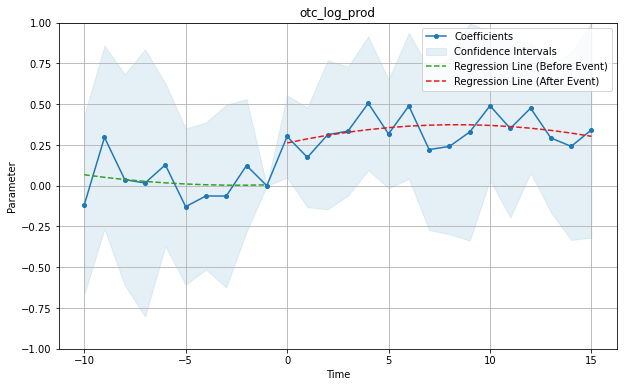

In [25]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_otc_rx_lag"
# ytrend
formula+=ytrend
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_prod",title="otc_log_prod",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)